In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from google.colab import drive
from google.colab import files
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
import random
from scipy.interpolate import UnivariateSpline


In [17]:
# Cell 3: Upload Data Function
def upload_data():
    """Upload your sensor data files"""
    uploaded = files.upload()
    return list(uploaded.keys())

In [18]:
# Cell 4: Data Loading and Preprocessing Functions
def load_and_prepare_data(file_paths):
    """
    Load and prepare the indoor air quality sensor data
    """
    # For a single file approach (recommended for time series)
    all_data = []

    for file_path in file_paths:
        # Load data
        df = pd.read_csv(file_path)

        # Convert datetime to datetime object
        df['datetime'] = pd.to_datetime(df['datetime'])

        # Sort by datetime
        df = df.sort_values('datetime')

        # Extract the parameters of interest
        selected_params = ['PM2_5.ug.m3.', 'PM10.ug.m3.', 'CO2.ppm.', 'Humidity..RH.']

        print(f"Loaded data from {file_path}")
        print(f"Total rows: {len(df)}")

        # Store the data in the correct format for LSTM
        # For LSTM, we need [features, time_steps]
        param_data = []
        for param in selected_params:
            param_data.append(df[param].values)

        all_data.append(param_data)

    # Print diagnostic information
    for i, data_set in enumerate(all_data):
        print(f"Dataset {i+1} structure:")
        print(f"  Number of parameters: {len(data_set)}")
        print(f"  Time steps per parameter: {len(data_set[0])}")

    return all_data


In [19]:
# Cell 5: Data Split Function
def data_split(dat, train_hour, test_hour, test_period, stride):
    """
    Takes as input an array of list representing a time series (array of vectors).

    Args:
        dat: array of list representing time series
        train_hour: number of lags used for training LSTM (previous time steps to use)
        test_hour: how many predictions we want to make simultaneously
        test_period: How many timesteps ahead to make prediction
        stride: How much time to stride ahead by

    Returns:
        numpy arrays x,y consisting of features/labels in format [samples, sensors, timesteps]
    """
    print('Data shape = ', len(dat), 'and ', len(dat[0]))
    # Safety check - make sure we have enough data
    total_required_steps = train_hour + test_period + test_hour
    if len(dat[0]) < total_required_steps:
        print(f"WARNING: Not enough time steps! Have {len(dat[0])}, need at least {total_required_steps}")

        # Adjust parameters if needed
        if len(dat[0]) > 5:  # Minimum reasonable threshold
            # Suggest better parameters
            suggested_train = max(1, int(len(dat[0]) * 0.6))
            suggested_test = 1
            suggested_period = 1
            print(f"Suggested parameters: train_time={suggested_train}, test_hour={suggested_test}, test_period={suggested_period}")

    # Create samples for training data
    x = []
    y = []

    # This is the missing code to create samples
    for i in range(0, len(dat[0]) - train_hour - test_period - test_hour + 1, stride):
        # For each time step
        if i + train_hour + test_period + test_hour <= len(dat[0]):
            # Create input sample
            x_sample = []
            for sensor in dat:
                x_sample.append(sensor[i:i+train_hour])
            x.append(x_sample)

            # Create output sample
            y_sample = []
            for sensor in dat:
                y_sample.append(sensor[i+train_hour+test_period:i+train_hour+test_period+test_hour])
            y.append(y_sample)

    # Transpose axes to [samples, time_steps, features]
    x = np.array(x).transpose(0, 2, 1)  # New shape: (samples, time_steps, features)
    y = np.array(y).transpose(0, 2, 1)

    print(f"X shape: {x.shape}, Y shape: {y.shape}")
    return x, y

In [20]:
# Cell 6: Data Normalization Function (Min-Max Scaling)
def data_normalize(dat):
    """
    Normalize data using Min-Max scaling
    """
    new_dat = []
    for d in dat:
        d_array = np.array(d)
        mask = d_array != -1
        valid_values = d_array[mask]

        if len(valid_values) > 0:
            min_val = np.min(valid_values)
            max_val = np.max(valid_values)
            # Avoid division by zero
            denominator = max_val - min_val + 1e-7
            d_array[mask] = (d_array[mask] - min_val) / denominator
        else:
            d_array[mask] = 0.0  # Default if no valid data

        new_dat.append(d_array.tolist())

    return new_dat

In [21]:
# Cell 7: Interpolation Function
def interpolate(data, mask=-1):
    """
    Interpolate missing values marked with mask value

    Args:
        data: List of data arrays to interpolate
        mask: Value representing missing data

    Returns:
        Interpolated data
    """
    temp = [list(dd) for dd in data]
    d = []

    for i in range(len(temp)):
        for j in range(len(temp[i])):
            if temp[i][j] == mask:
                temp[i][j] = float("NaN")

        # Use pandas Series for interpolation
        df = pd.Series(temp[i]).interpolate(method='linear')
        d.append(df.tolist())

    return d

In [22]:
# Cell 8: Split Training and Testing Data
def split_train(int_dat, norm_dat, train_time, predict_time, predict_position, stride, start, end):
    """
    Split data into training and testing sets
    """
    # Ensure we're working with the first dataset if there are multiple
    if isinstance(int_dat[0], list):
        int_dat = int_dat[0]
    if isinstance(norm_dat[0], list):
        norm_dat = norm_dat[0]

    length = len(int_dat[0])  # Get number of time steps
    print(f"Total time steps available: {length}")

    # Calculate indices for train/test split
    s = int(length * start)
    e = int(length * end)

    # Create training and testing sets
    train = [n[:s] for n in norm_dat]
    test = [m[s:e] for m in int_dat]

    print(f"Training set time steps: {len(train[0])}")
    print(f"Test set time steps: {len(test[0])}")

    # Check if we have enough data
    min_required = train_time + predict_position + predict_time
    if len(train[0]) < min_required:
        print(f"WARNING: Training set has insufficient time steps. Have {len(train[0])}, need {min_required}")
        # Adjust parameters if necessary
        if len(train[0]) > 5:
            new_train_time = max(1, int(len(train[0]) * 0.5))
            new_predict_position = 1
            new_predict_time = 1
            print(f"Adjusting parameters to: train_time={new_train_time}, predict_position={new_predict_position}, predict_time={new_predict_time}")
            train_time = new_train_time
            predict_position = new_predict_position
            predict_time = new_predict_time

    # Create samples
    train_x, train_y = data_split(train, train_time, predict_time, predict_position, stride)
    test_x, test_y = data_split(test, train_time, predict_time, predict_position, stride)

    return train_x, train_y, test_x, test_y

In [23]:
# Cell 9: Flatten Function
def flatten(p):
    """
    Flatten batch time series data into a matrix

    Args:
        p: Batch time series data

    Returns:
        Flattened matrix
    """
    pred_y_matrix = [[] for _ in range(len(p[0]))]

    for pp in p:
        a = pp.tolist()
        for m in range(len(a)):
            pred_y_matrix[m] += a[m]

    pred_y_matrix = np.array(pred_y_matrix)
    return np.array(pred_y_matrix).reshape((pred_y_matrix.shape[0], pred_y_matrix.shape[1]))

In [24]:
# Cell 10: Evaluation Metrics Function
def calculate_mae(py, ty):
    """
    Calculate Mean Absolute Error for each sensor parameter

    Args:
        py: Predicted values
        ty: True values

    Returns:
        MAE and standard deviation for each parameter
    """
    print('Predict data size: ', len(py), len(py[0]))
    print('Exact data size: ', len(ty), len(ty[0]))

    mae_list = []
    std_list = []

    for i in range(len(py)):
        # Convert back from log scale
        pred_values = np.exp(np.array(py[i]))
        true_values = np.exp(np.array(ty[i]))

        # Calculate absolute error
        abs_error = np.abs(pred_values - true_values)

        # Calculate mean and standard deviation
        mae_list.append(np.mean(abs_error))
        std_list.append(np.std(abs_error))

        print(f"Parameter {i+1} - MAE: {mae_list[-1]:.4f}, STD: {std_list[-1]:.4f}")

    return mae_list, std_list

In [25]:
# Cell 11: Visualize Predictions Function
def visualize_predictions(py, ty, param_names):
    """
    Visualize the predictions against the true values

    Args:
        py: Predicted values
        ty: True values
        param_names: Names of the parameters
    """
    # Convert back from log scale
    pred_values = np.exp(np.array(py))
    true_values = np.exp(np.array(ty))

    # Create subplots
    fig, axes = plt.subplots(len(py), 1, figsize=(15, 4 * len(py)))

    for i in range(len(py)):
        if len(py) == 1:
            ax = axes
        else:
            ax = axes[i]

        # Plot true values
        ax.plot(true_values[i], label='Actual', color='blue')

        # Plot predicted values
        ax.plot(pred_values[i], label='Predicted', color='red')

        # Add labels and title
        ax.set_title(f'{param_names[i]} Prediction')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel(param_names[i])
        ax.legend()

    plt.tight_layout()
    plt.show()

In [26]:
# Cell 12: Heatmap Visualization Function
def visualize_heatmaps(test_y, pred_y):
    """
    Visualize heatmaps of true values, predicted values, and their difference

    Args:
        test_y: True values
        pred_y: Predicted values
    """
    # Reshape data
    test_y = test_y.reshape(test_y.shape[0], test_y.shape[1], test_y.shape[2])
    pred_y = pred_y.reshape(pred_y.shape[0], pred_y.shape[1], pred_y.shape[2])

    # Flatten the data
    py = flatten(pred_y)
    ty = flatten(test_y)

    # Determine min and max values for consistent color scale
    min_val, max_val = np.min(ty), np.max(ty)

    # Create heatmaps
    plt.figure(figsize=(12, 5))
    ax1 = sns.heatmap(np.array(ty).T, vmin=min_val, vmax=max_val, cmap='viridis')
    ax1.set_title('Actual Data')
    ax1.set(xlabel='Parameters', ylabel='Time Step')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    ax2 = sns.heatmap(np.array(py).T, vmin=min_val, vmax=max_val, cmap='viridis')
    ax2.set_title('Predicted Data')
    ax2.set(xlabel='Parameters', ylabel='Time Step')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    error = np.array(py).T - np.array(ty).T
    ax3 = sns.heatmap(error, cmap='coolwarm', center=0)
    ax3.set_title('Error Map')
    ax3.set(xlabel='Parameters', ylabel='Time Step')
    plt.tight_layout()
    plt.show()

    # Calculate and return MAE and STD
    mae_list, std_list = calculate_mae(py, ty)

    print(f"Overall MAE: {np.mean(mae_list):.4f}")
    print(f"Overall STD: {np.mean(std_list):.4f}")

    return mae_list, std_list

In [27]:
# Cell 13: Stabilized LSTM Model
def stacked_LSTM(X, Y, name, epochs=50, batch_size=256):
    time_step = X.shape[1]  # Time steps
    input_dim = X.shape[2]  # Features
    out = Y.shape[2]

    model = Sequential()
    # Simplified architecture with gradient clipping
    model.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(time_step, input_dim)))
    model.add(Dense(out))

    # Adam optimizer with gradient clipping
    from keras.optimizers import Adam
    optimizer = Adam(clipvalue=0.5)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    # Early stopping
    callback = callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.001)

    hist = model.fit(X, Y, epochs=epochs, validation_split=0.2,
                     verbose=1, batch_size=batch_size, callbacks=[callback])

    return model, hist

In [14]:
# Cell 14: Main Function to Run the SPATIAL Model
def SP_Learner(data, data_name, param_names, train_split=0.8, test_split=1.0, train_time=6,
               predict_time=1, predict_position=1, stride=1, normalize=True, epochs=50, batch_size=256):
    """
    Main function to run the SPATIAL LSTM model

    Args:
        data: List of data arrays
        data_name: Name for the dataset
        param_names: Names of the parameters
        train_split: Proportion of data to use for training
        test_split: End proportion of data
        train_time: Number of time steps to use for training
        predict_time: Number of time steps to predict
        predict_position: How many time steps ahead to predict
        stride: Stride for creating samples
        normalize: Whether to normalize the data
        epochs: Number of training epochs
        batch_size: Batch size for training

    Returns:
        Predicted values, true values, error metrics, and trained model
    """
    print('######################## Starting SPATIAL LSTM Training ##################################')

    # Normalize data if requested
    if normalize:
        print('Normalizing data using log transformation')
        norm_dat = data_normalize(data)
        norm_int_dat = interpolate(norm_dat, -1)
    else:
        print('Using raw data without normalization')
        norm_dat = data
        norm_int_dat = interpolate(data, -1)

    # Split data
    train_x, train_y, test_x, test_y = split_train(
        norm_int_dat, norm_dat, train_time, predict_time, predict_position, stride, train_split, test_split
    )

    # Debug: Check for NaNs/Infs
    print("NaN in train_x:", np.isnan(train_x).any())
    print("Inf in train_x:", np.isinf(train_x).any())

    # Train model
    model, hist = stacked_LSTM(train_x, train_y, data_name, epochs, batch_size)

    # Make predictions
    pred_y = model.predict(test_x, verbose=1)

    print('Dimensions of the output data =', pred_y.shape, test_y.shape)

    # Visualize results
    mae, std = visualize_heatmaps(test_y, pred_y)

    # Visualize predictions for each parameter
    py = flatten(pred_y)
    ty = flatten(test_y)
    visualize_predictions(py, ty, param_names)

    print('Overall MAE:', np.mean(mae), 'STD:', np.mean(std))
    print('######################## Finished SPATIAL LSTM Training ##################################')

    return py, ty, mae, std, model, hist

In [28]:
# Cell 15: Plot Training History Function
def plot_training_history(history):
    """
    Plot the training history

    Args:
        history: Training history from model.fit()
    """
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

Loaded data from /content/drive/MyDrive/Ửok/Colab notebooks/Sensor/02_15mins.csv
Total rows: 17570
Loaded data from /content/drive/MyDrive/Ửok/Colab notebooks/Sensor/04_15mins.csv
Total rows: 17570
Dataset 1 structure:
  Number of parameters: 4
  Time steps per parameter: 17570
Dataset 2 structure:
  Number of parameters: 4
  Time steps per parameter: 17570
######################## Starting SPATIAL LSTM Training ##################################
Normalizing data using log transformation
Total time steps available: 17570
Training set time steps: 14056
Test set time steps: 3514
Data shape =  4 and  14056


<ipython-input-21-ceeccec50264>:22: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = pd.Series(temp[i]).interpolate(method='linear')


X shape: (14048, 6, 4), Y shape: (14048, 1, 4)
Data shape =  4 and  3514
X shape: (3506, 6, 4), Y shape: (3506, 1, 4)
NaN in train_x: True
Inf in train_x: False


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: nan - val_loss: nan
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: nan - val_loss: nan
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: nan - val_loss: nan
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: nan - val_loss: nan
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Dimensions of the output data = (3506, 6, 4) (3506, 1, 4)


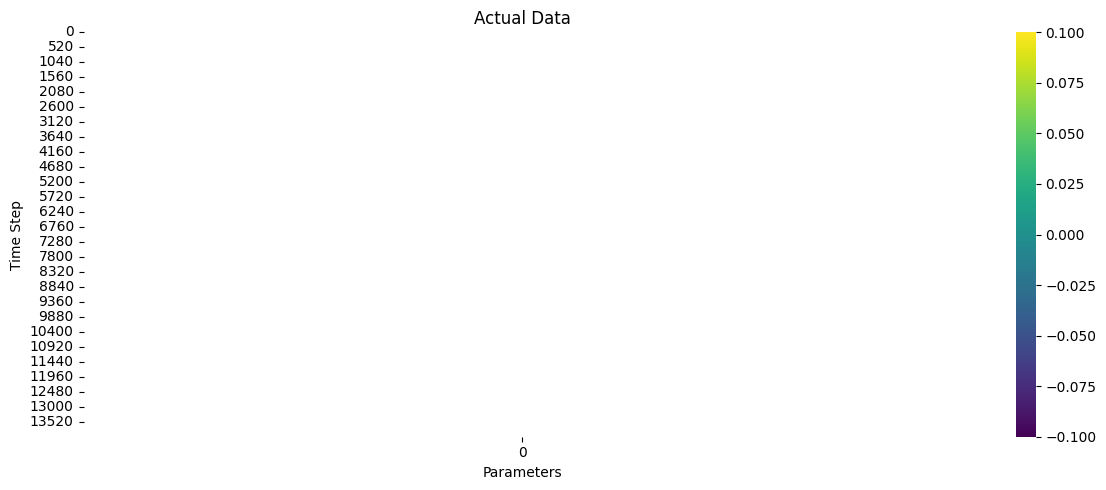

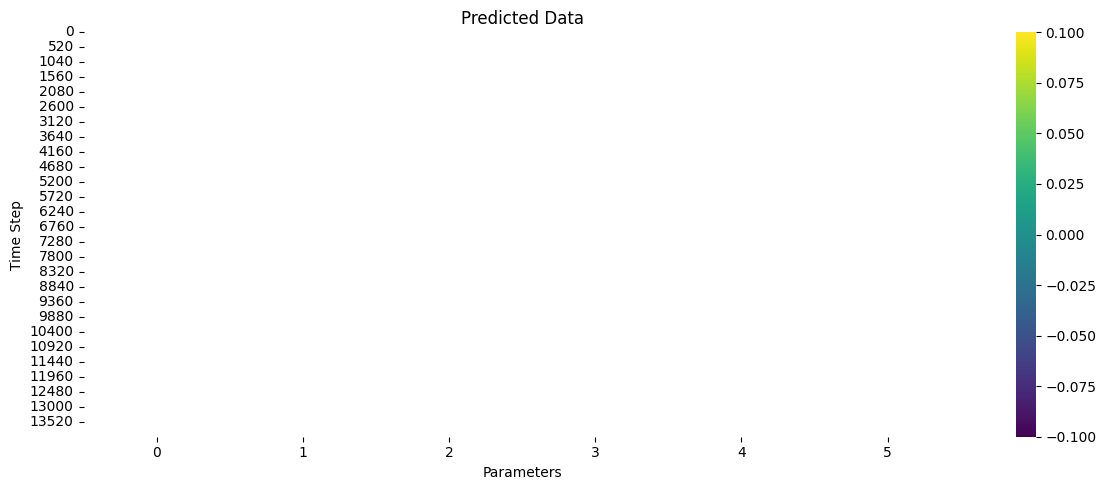

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


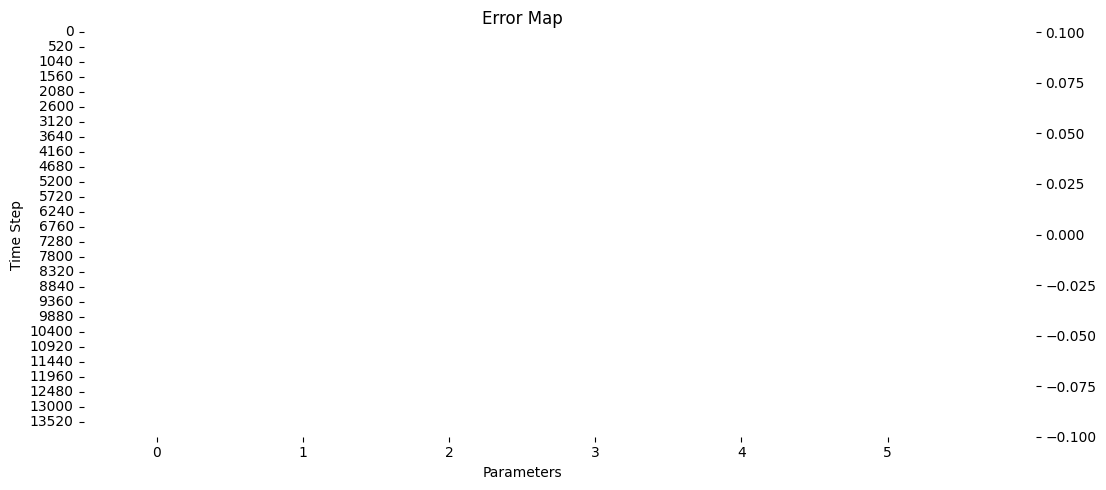

Predict data size:  6 14024
Exact data size:  1 14024
Parameter 1 - MAE: nan, STD: nan


IndexError: index 1 is out of bounds for axis 0 with size 1

In [29]:
# Cell 16: Main Execution (Updated Parameters)
# Define parameter names for visualization
param_names = ['PM2.5', 'PM10', 'CO2', 'Humidity']

# Upload your data files
file_paths = [
    '/content/drive/MyDrive/Ửok/Colab notebooks/Sensor/02_15mins.csv',
    '/content/drive/MyDrive/Ửok/Colab notebooks/Sensor/04_15mins.csv'
]

# Load data
sensor_data = load_and_prepare_data(file_paths)

# Run SPATIAL LSTM with safer parameters
predictions, actuals, mae, std, model, hist = SP_Learner(
    data=sensor_data,
    data_name='Indoor Air Quality',
    param_names=param_names,
    train_split=0.8,
    test_split=1.0,
    train_time=6,       # Reduced from 12 to 6 for stability
    predict_time=1,
    predict_position=2, # Reduced from 4 to 2
    stride=1,
    normalize=True,
    epochs=30,          # Reduced epochs
    batch_size=64       # Smaller batch size
)

# Plot training history
plot_training_history(hist)